# Radiation Exposure of Flight Crews on United Airlines

Steve Matsumoto (<smatsumoto@olin.edu>)

**This is a sample project, in the form of a computational essay. You should not try to replicate this in one pass - there were at least three iterations of the model I went through in this process, and you should start with the simplest possible model. There is also a lot of programming here t

## Question

Air travel carries many risks. Most members of the general public are aware of risks such as flight delays, lost or damaged luggage, or extra security screenings. However, many people are unaware or underinformed when it comes to radiation. At the cruising altitude of commercial flights (usually around 30,000 feet), there is less atmosphere in between passengers/crewmembers and cosmic [ionizing radiation](https://en.wikipedia.org/wiki/Ionizing_radiation#Air_travel), and thus anyone on these flights faces [increased doses of radiation](https://hps.org/publicinformation/ate/faqs/commercialflights.html). There is quite a bit of ongoing work about the [health risks of cosmic ionizing radiation](https://www.cdc.gov/niosh/topics/aircrew/cosmicionizingradiation.html), but it is generally considered good advice to minimize radiation exposure.

Because of the frequency with which they fly, airline crewmembers have a particularly high radiation exposure relative to the rest of the population, and some airlines have measures in place to limit this exposure by restricting how often or how far their crewmembers can fly in a given amount of time. In this project, I attempt to answer the following question:

**How many flight crews should United have on staff to maintain a reasonably safe level of radiation exposure for the average crew?**

Even though this is a design question, its answer can also help us understand more about the world of air travel. It may help us predict the harm that increasing air travel will do to both the environment and to the workers servicing these flights. It may also help us explain why flight delays sometimes occur due to crew changes: radiation exposure does play a part in those decisions.

## Methodology

To answer this question, I model domestic inter-hub flights on United Airlines using historical flight data and use this to simulate the average amount of radiation that an average crewmember is exposed to. Below, I describe the three major facets of my model: the state it keeps track of, the parameters and actions that determine how the state changes over time, and the metrics I will record to help in answering the central question.

### State

My model deals with the movement of flight crews among United's hub airports and their accumulating radiation levels as they travel. Therefore, the state of the model will track a number of flight crews and store for each crew their current hub airport and their total radiation exposure thus far. To simplify the representation of the state, I assume the following:

* The number of crews at United Airlines stays constant, so the model is always tracking the same number of crews through a simulation.
* Each crew has a constant set of members and does not split or merge, so a crew is always at a single airport and has a single level of radiation exposure.
* We only need to track future radiation exposure, so everyone initially starts with no radiation exposure.

These assumptions allow us to represent this part of the model state as a two-dimensional Pandas DataFrame: each row represents a crew, and the columns represent the airport and total radiation exposure of the crew.

To implement this representation, we can start by defining United's seven [hub airports](https://en.wikipedia.org/wiki/United_airlines#Hubs):

* O'Hare International Airport (ORD) in Chicago, IL
* Denver International Airport (DEN)
* George Bush Intercontinental Airport (IAH) in Houston, TX
* Los Angeles International Airport (LAX)
* Newark Liberty International Airport (EWR)
* San Francisco International Airport (SFO)
* Dulles International Airport (IAD) in Washington, DC

We will represent this set simply as a list:

In [50]:
HUBS = ['ORD', 'DEN', 'IAH', 'LAX', 'EWR', 'SFO', 'IAD']

The variable name `HUBS` is in all caps to indicate that we should assume it to reman constant throughout the simulation.

For measuring radiation exposure, I use the sievert (Sv), which is used as a standard unit of measurement for radiation exposure in humans, and represents the biological effect of 1 joule of radiation energy into a kilogram of human tissue. For this model, I specifically measure radiation exposure in  microsieverts (μSv), which is the right scale given the exposure in typical domestic flight within the United States.

Because the central question of this project is about the total number of crews that United should employ, we should also make sure that there are enough crews to handle the volume of flights out of each airport. Therefore, we can also track the number of times that a flight attempts to leave an airport without a crew. This can simply be an integer included with the state.

Because we represent the location and radiation of the crews as a data frame, we first need to import Pandas:

In [51]:
import pandas as pd

Now we can define the function that takes a set of initial conditions (the number of crews initially at each hub airport) and returns a data frame representing those conditions.

In [52]:
def make_crew_locations(ord, den, iah, lax, ewr, sfo, iad):
    """
    Initialize and return a state representing the location and miles traveled
    of airline crews at United's hub airports.
    
    NOTE: There is a better way to implement this function, but it requires
          programming techniques beyond the scope of this course.
    
    Args:
        ord: the number of crews initially at ORD.
        den: the number of crews initially at DEN.
        iah: the number of crews initially at IAH.
        lax: the number of crews initially at LAX.
        ewr: the number of crews initially at EWR.
        sfo: the number of crews initially at SFO.
        iad: the number of crews initially at IAD.
        
    Returns:
        A Pandas DataFrame representing the initial state of the system.
    """
    rows = []
    # For all of these loops, we don't use the value of the counter (usually
    # represented by i). We can explicitly ignore it by using an underscore.
    for _ in range(ord):
        # We can add new items to the end of a list by using append. Our list
        # holds rows, which each have two columns, so append a list of two
        # items to represent the two columns.
        rows.append(['ORD', 0])
    for _ in range(den):
        rows.append(['DEN', 0])
    for _ in range(iah):
        rows.append(['IAH', 0])
    for _ in range(lax):
        rows.append(['LAX', 0])
    for _ in range(ewr):
        rows.append(['EWR', 0])
    for _ in range(sfo):
        rows.append(['SFO', 0])
    for _ in range(iad):
        rows.append(['IAD', 0])
    return pd.DataFrame(rows, columns=['Current Airport',
                                       'Total Radiation Exposure (μSv)'])

In the `for` loops, the underscore (`_`) indicates that we do not need to use the value of the loop counter.

As an example, you can uncomment and run the cell below to see what an initialized data frame looks like. Feel free to change the parameters.

In [55]:
#make_crew_locations(3, 1, 2, 3, 3, 2, 2)

We can now define a function to make a state with a set of parameters. First we need to import the ModSim library.

In [56]:
from modsim import State

In [57]:
def make_state(ord, den, iah, lax, ewr, sfo, iad):
    """                                                                |
    Make a new state object containing the number of crews at each hub
    airport.
    
    Args:
        ord: the number of initial crews at O'Hare.
        den: the number of initial crews at DIA.
        iah: the number of initial crews at Bush.
        lax: the number of initial crews at LAX.
        ewr: the number of initial crews at Newark.
        sfo: the number of initial crews at SFO.
        iad: the number of initial crews at Dulles.
        
    Returns:
        A state object containing the specified number of crews at each
        airport, along with no insufficient crews.
    """
    initial_crew_locations = make_crew_locations(ord, den, iah, lax, ewr, sfo, iad)
    state = State(crew_locations=initial_crew_locations, insufficient_crews=0)
    return state

### Actions and Parameters

The state changes when a crew flies to another airport. At a given time step, each crew either stays at its current airport (leaving its radiation exposure level unchanged) or flies to a new airport and is exposed to some radiation. We can thus think of the model as having two types of parameters: first, some measure of how likely it is that a crew will fly from Airport X to Airport Y (or stay at Airport X), and second, the amount of radiation in microsieverts that a crewmember is exposed to when flying from Airport X to Airport Y. We can use the term *flight segment* to refer to a flight between airports; in a flight segment from ORD to DEN, we call ORD the *origin* and DEN the *destination*.

For the first type of parameter, rather than simply providing the probability that a crew will fly on some flight segment, I instead provide the *average number of flights per day* on a given flight segment. This parameter will allow us to select a set of crews for each flight segment on each day, and works better given the data we have to work with. 

Since we have seven hub airports, there are many possible flight segments, 42 to be exact. This also means we have a lot of parameters: for each flight segment, there is the average number of flights per day and the amount of radiation exposure. Of course, the number of overall flight crews at United and number of days for which we run the simulation are also parameters.

So to summarize, the parameters of the system are:

* The average number of flights per day on each flight segment (42 total)
* The radiation exposure of each flight segment (42 total)
* The total number of crews at hub airports
* The number of time steps for which we run the simulation

#### Data-Driven Parameters

While in the simulation I assume the values of the system parameters above, it is helpful to explain and justify these assumptions with data.

Much of the data I used to determine the system parameters came from the Bureau of Transportation Statistics (BTS), which operates under the US Department of Transportation. Specifically, I used the T-100 Domestic Segment data from the BTS's [Air Carrier Statistics Database](https://www.transtats.bts.gov/tables.asp?db_id=111&DB_Name=Air%20Carrier%20Statistics%20%28Form%2041%20Traffic%29-%20All%20Carriers#). This data set has quite a lot of information, far more than what I need for the model, and is also not formatted well for the purposes of this model. In the Appendix section, I describe how I cleaned the data for easier processing, so we can assume that the data we are working with looks like this:

```
Origin,Destination,Passengers,Airtime
LAX,SFO,35675,16744
DEN,IAD,20720,20018
IAH,SFO,34879,54682
...
```

This data is for February 2019 and as of the writing of this notebook (September 2019) is the latest available data from the BTS. In the data set, "Passengers" denotes the number of passengers carried on the segment for the whole month, and "Airtime" denotes the number of minutes spent in the air for all flights that month. Unfortunately, the number of flights made in a month was not available in the data set, so we have to use the number of passengers and minutes in the air as proxy values to determine the system parameters.

To determine the average number of flights per day on each flight segment, I assumed that each flight transports 180 passengers, based on the capacities of [United's aircraft fleet](https://www.united.com/web/en-US/content/travel/inflight/aircraft/default.aspx).

In [58]:
PASSENGERS_PER_FLIGHT = 180

Since this data is from February 2019, we expect that the data is for 28 days of flying.

In [59]:
DAYS_IN_MONTH = 28

In estimating the radiation exposure level of a flight segment, I assumed that radiation exposure is purely determined by time in the air. (In reality, the amount of radiation exposure is determined by longitude, latitude, and altitude over time.) In particular, we can use an estimate of 3.9 microsieverts (μSv) per hour of airtime, based on the highest exposure rate for a domestic US flight as mentioned in a short information page by the [Health Physics Society](https://hps.org/publicinformation/ate/faqs/commercialflights.html).

In [60]:
RADIATION_PER_HOUR = 3.9

We define the file we will read our data from:

In [61]:
data_file = 'processed_flight_data.csv'

We can read this file into a Pandas DataFrame:

In [62]:
flight_data = pd.read_csv(data_file)

We can define a function that makes it easier to get the passenger and airtime values out of the dataframe.

In [63]:
def get_segment_value(frame, origin, destination, value_type):
    """                                                                |
    Get a data value for a given origin and destination airport pair.
    
    Args:
        frame: the data frame representing the parameter data.
        origin: the origin airport code.
        destination: the destination airport code.
        value_type: the name of the column to read the value out of.
        
    Returns:
        The value of the cell with the specified origin, destination,
        and value type.
    """
    segment_row = frame.loc[(frame['Origin'] == origin)
                            & (frame['Destination'] == destination)]
    return segment_row.iloc[0][value_type]

With this function, we can define a function that converts a number of passengers per month to average flights per day.

In [64]:
def avg_flights_per_day(frame, origin, destination):
    """                                                                |
    Calculate the average flights per day from a data frame.
    
    Args:
        frame: the data frame representing the parameter data.
        origin: the segment origin's airport code.
        destination: the segment destination's airport code.
        
    Returns:
        The average number of flights per day for the given segment.
    """
    if origin == destination:
        return 0
    passengers = get_segment_value(frame, origin, destination,
                                   'Passengers')
    flights_per_month = passengers / PASSENGERS_PER_FLIGHT
    flights_per_day = flights_per_month / DAYS_IN_MONTH
    return flights_per_day

We can also define a function that converts monthly airtime in minutes to microsieverts per flight, using the number of monthly passengers to estimate the average flight time on a segment.

In [65]:
def radiation_per_segment(frame, origin, destination):
    """                                                                |
    Calculate the average radiation for a given flight segment.
    
    Args:
        frame: the data frame representing the parameter data.
        origin: the segment origin's airport code.
        destination: the segment destination's airport code.
    
    Returns:
        The average radiation exposure of the flight segment in
        microsieverts.
    """
    if origin == destination:
        return 0
    passengers = get_segment_value(frame, origin, destination,
                                   'Passengers')
    flights_per_month = passengers / PASSENGERS_PER_FLIGHT
    airtime = get_segment_value(frame, origin, destination, 'Airtime')
    avg_flight_minutes = airtime / flights_per_month
    avg_flight_hours = avg_flight_minutes / 60
    avg_radiation = RADIATION_PER_HOUR * avg_flight_hours
    return avg_radiation

We can then define a function that uses the above two functions to populate a matrix of parameters for flights per day and radiation per segment. The sets of these parameters are represented as a data frame where both rows and columns represent hub airports. The flights per day and radiation from an airport to itself can be ignored, but for a nice square matrix, we set those values to zero.

In [66]:
def make_parameter_matrix(frame, parameter_function):
    """                                                                |
    Make a parameter matrix from data.
    
    Args:
        frame: the data frame representing the parameter data.
        parameter_function: the function to run on each segment to get
            the desired parameter value.
            
    Returns:
        A data frame representing the desired parameter values for each
        flight segment.
    """
    data = {}
    for origin in HUBS:
        values = []
        for destination in HUBS:
            values.append(parameter_function(frame, origin,
                                             destination))
        data[origin] = values
    parameters = pd.DataFrame.from_dict(data, orient='index',
                                        columns=HUBS)
    return parameters

With these functions, we can generate the set of parameters for each segment.

In [67]:
flight_parameters = make_parameter_matrix(flight_data, avg_flights_per_day)
radiation_parameters = make_parameter_matrix(flight_data, radiation_per_segment)

To see the actual set of parameters generated, uncomment the lines below and run the cells.

In [69]:
#flight_parameters

In [71]:
#radiation_parameters

As I expect, longer flights (corresponding to longer distances between airports) result in higher levels of radiation exposure.

Determining the initial number of crews to start with can be a bit tricky. As a baseline, I assume that each airport starts with enough crews to make all of the outgoing flights on a given day. We can see approximately how many crews this is by summing the columns of the daily flight parameter matrix:

In [72]:
flight_parameters.sum(axis=1)

ORD    38.892262
DEN    40.087698
IAH    40.588095
LAX    43.439087
EWR    38.819246
SFO    45.233730
IAD    19.916667
dtype: float64

A single parameter, which I call `alpha`, can be used to scale these numbers up or down, and then round to the nearest integer to determine how many crews will initially be at each airport. The following function tells us how to allocate the initial crews among airports.

In [73]:
def allocate_crews(flight_parameters, alpha):
    """                                                                |
    Allocate initial crews to airports.
    
    Given a set of average flights per day on each tracked flight
    segment and a ratio of total initial crews to total flights per day,
    allocate crews to starting airports in proportion with these
    numbers.
    
    Args:
        flight_parameters: a data frame representing the average number
            of flights per day on each segment.
        alpha: the ratio of total starting crews to total average
            flights per day on all segments.
        
    Returns:
        A series of crews representing the number of crews at each
        airport, in order of the airport's appearance in the labels of
        the flight parameters matrix.
    """
    avg_departures = flight_parameters.sum(axis=1)
    scaled_parameters = alpha * avg_departures
    scaled_crews = scaled_parameters.round().astype(int)
    return scaled_crews

We can use this function to find out how many total crews there are.

In [74]:
crews = allocate_crews(flight_parameters, 1)
crews.sum()

267

To make a system object, we need to import the relevant function from ModSim:

In [75]:
from modsim import System

We can then define a function to create a system object representing the parameters of a simulation, given the parameters from our data file and a value of `alpha`.

In [76]:
def make_system(flight_parameters, radiation_parameters, alpha):
    """                                                                |
    Make a system object from parameters.
    
    Args:
        flight_parameters: a data frame of the average daily flights on
            each flight segment.
        radiation_parameters: a data frame of the radiation exposure of
            each flight segment.
        alpha: the ratio of total starting crews to total average daily
            flights.
        
    Returns:
        A system object with the specified parameters.
    """
    starting_crews = allocate_crews(flight_parameters, alpha)
    system = System(flight_parameters=flight_parameters,
                    radiation_parameters=radiation_parameters,
                    starting_crews=starting_crews)
    return system

If you want, you can make a sample system object below and check the system variables to make sure that they are what you expect.

In [79]:
sample_system = make_system(flight_parameters, radiation_parameters, 0.5)
#sample_system
#sample_system.flight_parameters
#sample_system.radiation_parameters
#sample_system.starting_crews

### Actions

For simplicity, I assume that a flight crew takes no more than one flight a day, so the daily action consists of selecting flights from each airport to move, and recording the radiation exposure of each crew that moves.

We start the description by making a sample state object to use as an example:

In [80]:
sample_state = make_state(*sample_system.starting_crews)

The asterisk at the beginning of the function parameter tells the function to treat the elements of the list as if it were the parameters of the function in order. Since `make_state` takes the number of crews at each airport and `starting_crews` is the number of crews to start at each airport, this works out nicely.

The flight parameters for our model describe the average daily number of flights on each segment. A *Poisson distribution* is a probability distribution that can be used to generate a nonnegative number of flights per day with a given average, with values farther from the average being less likely. In deciding how many crews to move along a segment on a given day, we will use this distribution.

In Python, we can do this using NumPy. Let's import the module:

In [81]:
import numpy
from numpy.random import poisson

We can then generate from a Poisson distribution using the entire flight parameter matrix:

In [82]:
poisson(flight_parameters)

array([[ 0,  9,  5,  9,  6,  4,  1],
       [ 7,  0,  7, 11,  8, 13,  7],
       [ 7, 12,  0,  4,  3,  9,  0],
       [11,  2,  7,  0, 10,  5,  5],
       [11,  5, 11,  8,  0,  7,  3],
       [ 5,  3,  7,  4, 10,  0,  4],
       [ 4,  3,  0,  5,  1,  8,  0]])

Now we need to use this Poisson information to mark crews to move between airports. The `choice` function in NumPy allows us to select a random subset of a series, or a row/column of a Pandas DataFrame. Let's import it:

In [83]:
from numpy.random import choice

We can now define a function that finds all crews at an origin airport and choose a random subset of them to move to a new airport.

In [84]:
def mark_flight_crews(current_locations, origin, existing_marks, num_flights):
    """
    Select a random subset of crews at a given origin airport to mark for flight
    to a new airport.
    
    Given a current set of crew locations, select a subset of crews that are at
    a given airport to fly to a new airport. Selections are made only for crews
    that have not already been selected to fly to a different airport; these
    selections are indicated in `existing_marks`. The subset is chosen uniformly
    at random without replacement (so no crew can be selected twice), and the
    subset is of size `num_flights`.
    
    This function only returns the *indices* of the crews to be moved to a new
    airport and does not specify what new airport(s) to move the crews to. The
    caller of this function is responsible for interpreting the returned indices
    as moves to one or more airports, and is also responsible for actually
    moving the crews.
    
    Args:
        current_locations: a data frame of the current crew locations.
        origin: the origin airport.
        existing_marks: a list of updated airports for crews.
        num_flights: the number of crews at an origin airport to select.
    
    Returns:
        An array of indices indicating which crew numbers should be marked.
    """
    origin_indices = current_locations.loc[
        (current_locations == origin) & (current_locations == existing_marks)].index
    segment_marks = choice(origin_indices, size=num_flights, replace=False)
    return segment_marks

We can use `mark_flight_crews` in a function that selects a set of crews to move from a given origin airport to any other airport, and returns an updated list of crew locations given those flights.

In [85]:
import numpy

In [86]:
def select_departures(current_locations, flight_parameters, origin):
    """                                                                |
    Select a set of crews to move from a given origin airport.
    
    Given a set of current crew locations, a set of flight parameters,
    and an origin airport, select a random subset of the crews at the
    origin airport to mark for flights to other airports.
    
    Typically, the function uses the flight parameters to draw from
    Poisson distributions to determine the number of outgoing flights
    from an airport to each destination. If there are too many outgoing
    flights from the origin airport, this function randomly selects a
    subset of flights to mark as canceled due to a shortage of crews.
    
    This function does not make any changes to the set of current crew
    locations; the caller of this function is responsible for
    interpreting the results and making any updates to model state.
    
    Args:
        current_locations: a data frame or series of the current
            locations of crews.
        flight_parameters: a matrix representing the average daily
            flights along each segment.
        origin: a string representing the origin airport code.
        
    Returns:
        An integer representing the number of planned flights that did
        not depart due to crew shortages, and a list of updated crew
        locations given the selected flights.
    """
    # Get the list of crews at the origin airport.
    origin_crews = current_locations[current_locations == origin]
    num_origin_crews = len(origin_crews.index)
    
    # Get the number of flights from the origin to each destination,
    # generated fro`m a set of Poisson distributions.
    origin_parameters = flight_parameters.loc[origin]
    origin_flights = poisson(origin_parameters)
    
    # Determine if there are enough crews to make all flights from the
    # origin airport, and randomly cancel flights otherwise.
    total_departures = origin_flights.sum()
    insufficient_crews = 0
    if total_departures > num_origin_crews:
        crews_short = total_departures - num_origin_crews
        insufficient_crews += crews_short
        for _ in range(crews_short):
            # Select a scheduled flight segment (i.e., the number of
            # flights on that segment is currently nonzero) to cancel.
            departures = numpy.nonzero(origin_flights)[0]
            canceled_departure = choice(departures)
            origin_flights[canceled_departure] -= 1
            
    # Determine which airport each crew will be flying to and mark the
    # new location of each crew.
    updated_crew_locations = current_locations.copy()
    for i in range(len(HUBS)):
        marks = mark_flight_crews(current_locations, origin,
                                  updated_crew_locations,
                                  origin_flights[i])
        destination = HUBS[i]
        updated_crew_locations[marks] = destination
    return insufficient_crews, updated_crew_locations
    

We can then use `select_departures` to implement a function that updates the state in each step of a simulation.

In [87]:
def update_state(state, system):
    """                                                                |
    Update the model state based on the system parameters.
    
    Args:
        state: the current state of the model.
        system: the system object holding the parameters of the
            simulation.
    
    Returns:
        None. The state object is updated based on the flights taken by
        each crew that day.
    """
    # Make a copy of the current crew locations to use to mark crew
    # movements.
    current_locations = state.crew_locations['Current Airport']
    total_updates = current_locations.copy()
    
    # Mark departures from each origin airport and update locations in
    # the copy.
    for origin in HUBS:
        insufficient_crews, updates = select_departures(
            current_locations, system.flight_parameters, origin)
        state.insufficient_crews += insufficient_crews
        changes = total_updates[current_locations != updates].index
        total_updates[changes] = updates[changes]
        
    # Loop through the old and new locations and add the radiation
    # values to the state
    for i in range(len(state.crew_locations.index)):
        old_location = state.crew_locations.iloc[i, 0]
        new_location = total_updates.iloc[i]
        radiation_exposure = system.radiation_parameters.loc[old_location,
                                                             new_location]
        state.crew_locations.iloc[i, 1] += radiation_exposure
        state.crew_locations.iloc[i, 0] = new_location

### Metrics

With our model set up, we can now implement a function that runs a simulation. For flexibility, we can have the function return the entire state at the end of the simulation, rather than a specific metric.

In [88]:
def run_simulation(system, update_function, num_steps):
    """                                                                |
    Simulate a number of flights with radiation exposure.
    
    Given a system of parameters, a state update function, and a length
    of time in days, run a simulation covering the number of days. At
    the end of the simulation, return the end state of the system.
    
    Args:
        system: a system with the relevant parameters for the
            simulation.
        update_function: the function used to update the state each day.
        num_steps: the number of steps (days) to run the simulation.
        
    Returns:
        The state after `num_steps` days of the simulation.
    """
    state = make_state(*system.starting_crews)
    for _ in range(num_steps):
        update_function(state, system)
    return state

With our model set up, we can now measure the radiation exposure of the crews. Because there can be many crews, it makes sense to think about the amount of radiation the average crew would be exposed to in a month. But it is also helpful to consider the most radiation any crew would be exposed to in a month. The latter is not as helpful to get in a simulation, since a crew may just end up having very bad luck in a month, but it can be helpful to look at anyway. We can implement functions to get those metrics from a state.

In [89]:
def get_avg_radiation(state):
    """                                                                |
    Return the average radiation exposure of all crews.
    
    Args:
        state: the state object holding the radiation exposure levels.
        
    Returns:
        The average radiation exposure level in µSv.
    """
    radiation = state.crew_locations['Total Radiation Exposure (μSv)']
    return radiation.mean()

def get_max_radiation(state):
    """                                                                |
    Return the maximum radiation exposure of all crews.
    
    Args:
        state: the state object holding the radiation exposure levels.
        
    Returns:
        The maximum radiation exposure level in µSv.
    """
    radiation = state.crew_locations['Total Radiation Exposure (μSv)']
    return radiation.max()

Intuitively, too few crews will also be bad for United, not only because of the higher radiation exposure per crew, but because there will simply not be enough crews to serve all of the flights. So it is helpful to take a look at how many flights are canceled due to insufficient crews. While this number is somewhat independent of the radiation exposure, it will help us tie the model to reality, since United will likely make their decision of how many crews to employ based on how many flights they have per day. We can define a function to get this value as well.

In [90]:
def get_canceled_flights(state):
    """                                                                |
    Return the number of canceled flights.
    
    Args:
        state: the state object holding the number of canceled flights.
        
    Returns:
        The maximum radiation exposure level in µSv.
    """
    return state.insufficient_crews

It may seem silly to define such a simple function, but providing a consistent way to get metrics from our model - that is, having a function take a state and return a value - makes it much easier to get other metrics from our model in the future if we want.

Because we are trying to answer the question of how many crews should be on staff, we can track these metrics against the number of flight crews. Remember that `alpha`, the the ratio of total crews to total daily flights, is helpful for initally allocating crews to airports, so we can use values of `alpha` in a parameter sweep. However, rather than setting the values of our sweep series based on `alpha`, we can compute the number of crews and use that number instead. Let's import the `SweepSeries` function from the ModSim library.

In [91]:
from modsim import SweepSeries

Our function will take a range of `alpha` values and create a number of sweep series. To keep things flexible, the function will combine those sweep series into a Pandas dataframe, making it easy to get and plot the specific series we want, even if we add more metrics later.

In [92]:
def sweep_parameters(alphas, flight_parameters, radiation_parameters,
                     update_function, num_steps):
    """                                                                |
    Run simulations with a range of parameters.
    
    Args:
        alphas: a range of alpha values to sweep.
        flight_parameters: a matrix representing the average daily
            flights along each segment.
        radiation_parameters: a matrix representing the radiation
            exposure of each flight segment.
        update_function: the function used to update the state each day.
        num_steps: the number of steps (days) to run the simulation.
        
    Returns: 
        A data frame representing sweep series of all the metrics
        collected.
    """
    # Create sweep series objects for each of the metrics.
    avg_radiation = SweepSeries()
    max_radiation = SweepSeries()
    canceled_flights = SweepSeries()
    
    # Run the simulation for each alpha value and get the desired
    # metrics out of the final state.
    for alpha in alphas:
        system = make_system(flight_parameters, radiation_parameters,
                             alpha)
        final_state = run_simulation(system, update_function, num_steps)
        crew_size = system.starting_crews.sum()
        avg_radiation[crew_size] = get_avg_radiation(final_state)
        max_radiation[crew_size] = get_max_radiation(final_state)
        canceled_flights[crew_size] = get_canceled_flights(final_state)
    
    # Turn the Sweep Series into named Pandas series and assemble them
    # into a single data frame.
    avg_radiation_series = pd.Series(avg_radiation,
                                     name='Average Radiation')
    max_radiation_series = pd.Series(max_radiation,
                                     name='Maximum Radiation')
    canceled_flights_series = pd.Series(canceled_flights,
                                        name='Canceled Flights')
    frame = pd.concat([avg_radiation_series, max_radiation_series,
                       canceled_flights_series], axis=1)
    return frame

Since we used monthly data to estimate the parameters for our simulation, let's run our simulation for a month. Just to make sure we have data for any month, we can run the simulation for 31 days.

In [93]:
DAYS_IN_MONTH = 31

We can import `linrange` from the ModSim library to generate our parameters.

In [94]:
from modsim import linrange
alphas = linrange(0.1, 3.1, 0.1)

We can now run our simulations. This will take a while.

In [95]:
frame = sweep_parameters(alphas, flight_parameters,
                         radiation_parameters, update_state,
                         DAYS_IN_MONTH)

## Results

We can now plot these results. To do this, let's import the necessary functions from the ModSim library.

In [96]:
from modsim import plot, decorate

We can then create a function to plot a desired series and label the plot.

In [97]:
def make_plot(series, title, xlabel, ylabel):
    plot(series)
    decorate(title=title, xlabel=xlabel, ylabel=ylabel)

Now, we can plot the metrics we collected earlier. First, we plot the average radiation exposure level.

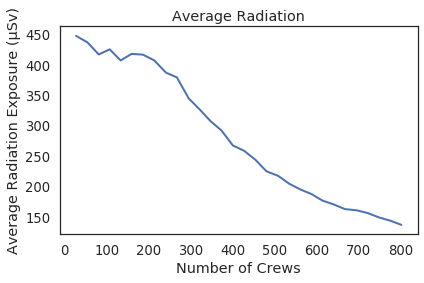

In [98]:
make_plot(frame['Average Radiation'], 'Average Radiation', 'Number of Crews', 
          'Average Radiation Exposure (µSv)')

We can then plot the maximum radiation exposure levels.

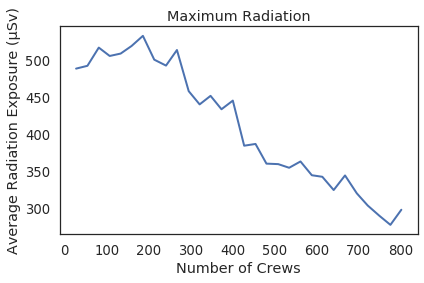

In [44]:
make_plot(frame['Maximum Radiation'], 'Maximum Radiation', 'Number of Crews', 
          'Average Radiation Exposure (µSv)')

Finally, we can plot the number of canceled flights.

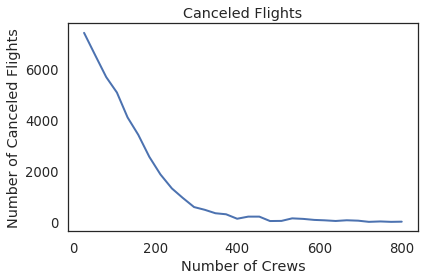

In [45]:
make_plot(frame['Canceled Flights'], 'Canceled Flights', 'Number of Crews', 
          'Number of Canceled Flights')

## Interpretation

These plots confirm our intuition: as the total number of crews increases, each one is exposed to less radiation, and fewer flights go unserviced.

According to information from the Health Physics Society, the recommended monthly dose limit for radiation exposure is about 500 µSv for airline crewmembers. It looks like even with only 0.1 crews per average daily flight (about 27 crews in total), the average radiation exposure is below this amount, which is a bit surprising. At this level, each crew is flying almost every day, since there are not enough of them to go around. In fact, looking at the plot of maximum radiation exposure, this limit is almost never exceeded, regardless of how many or few crews are on United's payroll.

Interestingly, according to a [CDC info page](https://www.cdc.gov/niosh/topics/aircrew/cosmicionizingradiation.html), the recommended exposure level for the general public in the US and for crews working in the EU, the recommended *yearly* dose is about 1000 µSv, which is about 83 µSv per month. Even with around 800 crews on staff (about 3 times the number of average daily flights), the average radiation level is significantly more than this amount. So it seems safe to say that crewmembers are exposed to significantly more radiation than is recommended for the general public.

So what is a reasonable level of radiation exposure? Since crewmembers likely expect to be exposed to a high amount of radiation, we could set a limit of twice that of the general public, or about 166 µSv per month. At this level, about 667 crews, or about 2.5 times the number of average daily flights, is recommended.

If we look at the number of canceled flights, it seems to level off around 400 crews, or around 1.5 times the number of daily average flights. So with 667 crews, United should be reasonably confident in its ability to maintain a decent on-time departure percentage, as well as a reasonable level of radiation exposure for its crews.

### Limitations

There are a number of limitations of this model. Most notably, there are far more airports than the seven hub airports I considered here. A few other limitations to consider:

* Crews typically have limits on how often they can fly, or how far they can fly in a given period of time. This is due to labor laws as well as radiation risks.
* Flights can have vastly differing capacities, particularly between short regional flights and longer flights. This can throw off our estimates for flight and radiation parameters, particularly considering segments such as Newark to Dulles (which are quite rare due to their proximity).
* This data is from February, which does not take into account travel patterns at more popular times, such as the summer months or December/January.

### Further Exploration

With more time, there are some further interesting questions I could explore. For example, if crews could set limits on how often they fly (e.g., once every 3 days), how would the average radiation level exposure change? How would the number of canceled flights change?

Also, we could make a number of changes to the model, including the concept of a home airport (which virtually every crewmember has) in which crews fly to and from that airport more often than other airports. If we consider multiple months, we can also change the number of flights among airports as we move through the months. In both of these cases, we could see if these changes have an effect on the number of crews that United needs to emply to limit radiation exposure of their crews and maintain an on-time departures schedule.

## Appendix

This data set is rather complex, but it is possible to select only the data that is needed when downloading. In this case, I chose to download information for February 2019 (the most recent month available). The data set is formatted as a CSV file, which can be interpreted similarly to a DataFrame. Each row represented a flight or set of flights, and the columns of the data set represented the following, in order.

* The number of passengers transported by the flight(s)
* The total air time of the flight(s)
* The operating airline's IATA identification code (in United's case, UA)
* The origin airport's IATA identification code (e.g., ORD for O'Hare)
* The destination airport's IATA identification code
* The month of flight (in the case of February, 2)

So the first few rows of the data looked like this:

```
"PASSENGERS","AIR_TIME","UNIQUE_CARRIER","ORIGIN","DEST","MONTH",
0.00,0.00,"UA","KOA","SFO",2,
0.00,0.00,"UA","OMA","DEN",2,
0.00,1661.00,"WI","ANC","ORD",2,
```

In order to process this data into a more useful format, we can do the following:

* Filter out all flights that carried no passengers or was not operated by United.
* Add the total number of passengers and air time of all records for a given segment (origin-destination pair).
* Assume that each flight transports 180 passengers, based on the capacities of [United's aircraft fleet](https://www.united.com/web/en-US/content/travel/inflight/aircraft/default.aspx).
* Use this to calculate the number of flights per month on each segment.
* Assume that radiation exposure is purely determined by time in the air. (In reality, the amount of radiation exposure is determined by longitude, latitude, and altitude over time.) I used an estimate of 4 microsieverts (μSv) per hour of flying, based on the highest exposure rate for a domestic US flight as mentioned in a short information page by the [Health Physics Society](https://hps.org/publicinformation/ate/faqs/commercialflights.html).
* Use this to calculate the radiation exposure of a flight on each segment.

First, we define a variable with the path to the raw data file.

In [46]:
raw_data_file = 'raw_flight_data.csv'

Then we import the modules we need to process the data.

In [47]:
import collections
import fileinput

In [48]:
# Make sure that the system object and its relevant variables from above are defined, since we use them here.
assert HUBS is not None and isinstance(HUBS, list)

def process_raw_data(raw_data_file, processed_data_file):

    """
    Clean and reformat the raw flight data from the BTS. The reformatted data is
    written to a new file. If a file with the path of processed_data_file
    already exists, it will be overwritten.
    
    Args:
        raw_data_file: a string representing the path to the raw data file.
        processed_data_file: a string representing the path to the processed
            data file.
    
    Returns:
        None.
    """
    
    # Set up the dictionaries used to keep track of total passengers and airtime
    # for a segment.
    segment_passengers = collections.defaultdict(int)
    segment_airtime = collections.defaultdict(int)
    
    for line in fileinput.input(raw_data_file):
        # Ignore the header line
        if line[0] == '"':
            continue
            
        # Parse out the data and ignore any line that indicates zero
        # passengers, a non-United flight, a non-interhub flight, or a flight
        # not in February.
        tokens = line.strip().split(',')
        # The raw data gives the number of passengers as a float, so we have to
        # convert from string to float and then to int
        passengers = int(float(tokens[0]))
        if passengers == 0:
            continue
        airtime = int(float(tokens[1]))
        # All of the text fields have quotes around them, so remove them
        airline = tokens[2].strip('"')
        if airline != 'UA':
            continue
        origin = tokens[3].strip('"')
        destination = tokens[4].strip('"')
        if origin not in HUBS or destination not in HUBS:
            continue
        month = int(tokens[5])
        if month != 2:
            continue
            
        # Add the passengers and airtime for the segment to the dictionaries.
        segment = origin + destination
        segment_passengers[segment] += passengers
        segment_airtime[segment] += airtime
    
    with open(processed_data_file, 'w') as output_file:
        # Print the header line to the file.
        print('Origin,Destination,Passengers,Airtime', file=output_file)
        
        # Write the remaining data to the file.


        for k in segment_passengers.keys():
            origin = k[:3]
            destination = k[3:]
            print('{},{},{},{}'.format(origin, destination,
                                       segment_passengers[k],
                                       segment_airtime[k]), file=output_file)        

We can then process the raw data into a more workable format:

In [49]:
assert data_file is not None and isinstance(data_file, str)
processed_data_file = data_file
process_raw_data(raw_data_file, processed_data_file)